In [3]:
import json
import numpy as np
import pandas as pd 
import os
import torch

from rl4uc.environment import make_env
from ts4uc.helpers import test_schedule
from ts4uc.agents.ppo_async.ac_agent import ACAgent

### Plot Training

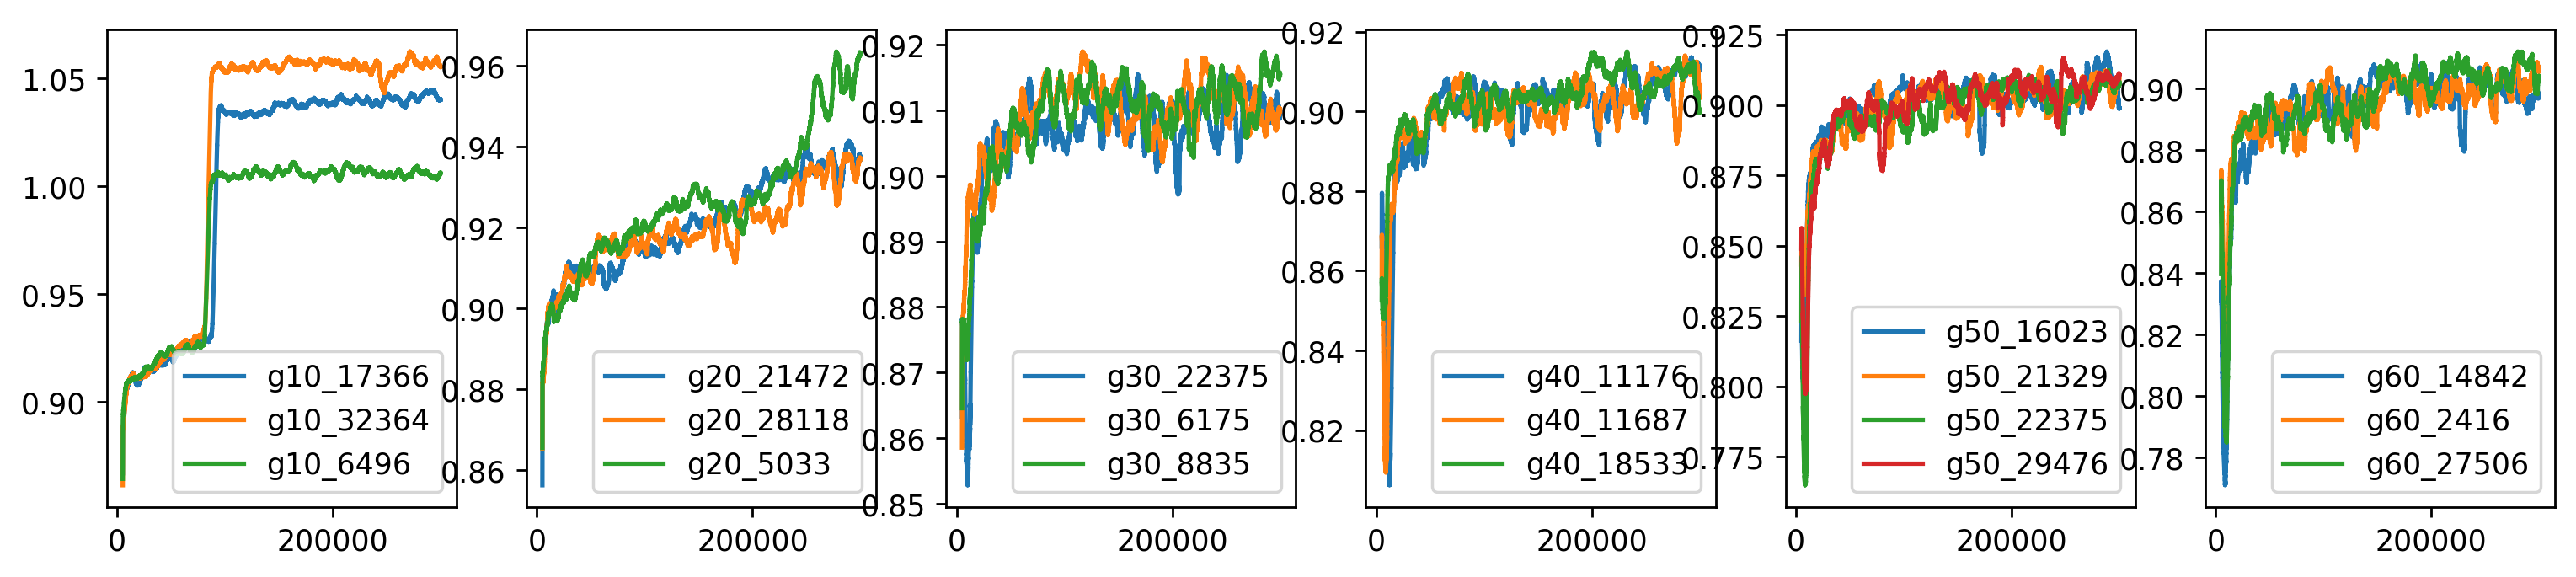

In [4]:
root_dir = 'results/22-08-26_policies'
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 6, dpi=250, figsize=(15, 3))

# record the best performing version by number of generators 
best_versions = {}

for i, num_gen in enumerate([10, 20, 30, 40, 50, 60]):
    ax = axs[i]
    
    ds = os.listdir(root_dir)
    ds.sort()
    
    best_ma = -np.inf

    for d in ds:
        p = os.path.join(root_dir, d)
        if os.path.isdir(p) is False:
            continue

        if f'g{num_gen}' not in d:
            continue

        rpt = pd.Series(np.genfromtxt(os.path.join(p, 'epoch_mean_rpt.txt')))
        ma = rpt.rolling(5000).mean()
        
        # updating best policies
        last_ma = ma.values[-1]
        if last_ma > best_ma: 
            best_ma = last_ma
            best_versions[num_gen] = int(d.split('_')[1])
        
        ax.plot(ma, label=d)
            
    ax.legend()


    

In [5]:
best_versions

{10: 32364, 20: 5033, 30: 8835, 40: 11176, 50: 29476, 60: 2416}

### Evaluating Policies

In [6]:
def solve_model_free(env, policy, deterministic=True):
    """
    Solve a UC problem using trained policy (no tree search)
    """
    obs = env.reset()
    final_schedule = np.zeros((env.episode_length, env.num_gen))
    for t in range(env.episode_length):
        a, sub_obs, sub_acts, log_probs = policy.generate_action(env, obs, argmax=deterministic)
        obs, reward, done = env.step(a, deterministic=True)
        final_schedule[t,:] = a
    return final_schedule

In [10]:
def evaluate_policy(policy_dir, test_dir='test_data_windy', n_days=None, deterministic=True, evaluate=True):
    """
    Evaluate a policy (saved in policy_dir) on a batch of test problems (test_dir)
    
    Setting deterministic=True takes an argmax over action probabiliies in policy \pi(a|s),
    otherwise actions are sampled from \pi. 
    
    Returns:
    
    - all_results: a pd.DataFrame of costs, load shedding etc. for each scenario 
    - schedules: dictionary of schedules 
    """

    params = json.load(open(os.path.join(policy_dir, 'params.json')))
    env_params = json.load(open(os.path.join(policy_dir, 'env_params.json')))

    env = make_env(num_gen=env_params['num_gen'])
    policy = ACAgent(env, **params)
    policy.load_state_dict(torch.load(os.path.join(policy_dir, 'ac_final.pt')))
    policy.eval()
    
    # Make a directory for storing the results to unseen problems
    save_dir = os.path.join(policy_dir, 'test_solutions')
    os.makedirs(save_dir, exist_ok=True)
    
    # If not producing deterministic solutions, then set seed and save in a separate directory
    if not deterministic: 
        np.random.seed()
        seed = np.random.choice(10000)
        torch.random.manual_seed(seed)
        np.random.seed(seed)
        save_dir = os.path.join(save_dir, f'random_{seed}')
        os.makedirs(save_dir, exist_ok=True)

    all_results = []
    schedules = {}
    
    fs = [x for x in os.listdir(test_dir) if '.csv' in x]
    fs.sort()
    
    if n_days is not None: 
        fs = fs[:n_days]

    for f in fs: 

        # Retrieve the date
        date = f.split('_')[1].split('.')[0]
        
        print(f"Running {date}...")

        # Solve the UC problem
        profile_df = pd.read_csv(os.path.join(test_dir, f))
        profile_df['wind'] = profile_df.wind * env.num_gen / 10.
        profile_df['demand'] = profile_df.demand * env.num_gen / 10.
        
        env = make_env(mode='test', profiles_df=profile_df, **env_params)
        schedule = solve_model_free(env, policy, deterministic=deterministic)
        schedules[date] = schedule
        
        if evaluate:
            # Evaluate the schedule over realisations of uncertainty
            results = test_schedule(env, schedule)
            results['date'] = date
            all_results.append(results)

    if evaluate: 
        # Concat and save the main results (costs, LOLP etc)
        all_results = pd.concat(all_results)
        all_results.to_csv(os.path.join(save_dir, 'results.csv'))
    
    # Save the solutions 
    for key, schedule in schedules.items(): 
        pd.DataFrame(schedule, dtype=int).to_csv(os.path.join(save_dir, f'{key}_RL.csv'), index=False)
    
    return all_results, schedules


In [11]:
# Use this code to solve all test problems for all generator sizes 
rerun = False
if rerun: 
    for num_gen in [10, 20, 30, 40, 50]:

        v = best_versions[num_gen]
        policy_dir = f'results/22-08-26_policies/g{num_gen}_{v}'

        all_results, schedules = evaluate_policy(policy_dir, evaluate=False, deterministic=False)


In [15]:
num_gen = 30
v = best_versions[num_gen]
policy_dir = f'results/22-08-26_policies/g{num_gen}_{v}'
all_results, schedules = evaluate_policy(policy_dir, evaluate=False, deterministic=False)

Gamma: 0.9486832980505138
Running 2016-01-12...
Running 2016-07-25...
Running 2016-11-21...
Running 2017-03-18...
Running 2017-04-07...
Running 2017-05-12...
Running 2017-05-26...
Running 2017-06-25...
Running 2017-12-18...
Running 2017-12-30...
Running 2018-01-15...
Running 2018-03-08...
Running 2018-03-18...
Running 2018-05-30...
Running 2018-09-11...
Running 2018-11-13...
Running 2019-04-03...
Running 2019-05-22...
Running 2019-10-30...
Running 2019-11-09...


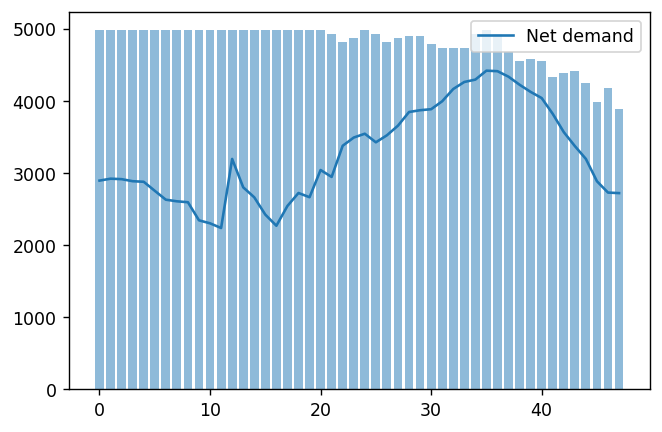

In [19]:
import matplotlib.pyplot as plt
env = make_env(num_gen=num_gen)

date = '2016-01-12'
test_dir = 'test_data_windy/'

df = pd.read_csv(os.path.join(test_dir, f'profile_{date}.csv'))
df['demand'] = df.demand * env.num_gen / 10
df['wind'] = df.wind * env.num_gen / 10

fig, ax = plt.subplots(dpi=125)

# ax.plot(np.dot(schedules[f'{date}'], env.max_output))
ax.bar(np.arange(48), np.dot(schedules[f'{date}'], env.max_output), alpha=0.5, width=0.8)


ax.plot(df.demand - df.wind, label='Net demand')

plt.legend()

<AxesSubplot:>

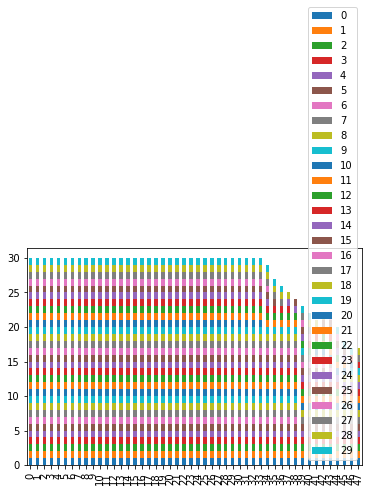

In [20]:
pd.DataFrame(schedules['2016-07-25']).plot(kind='bar', stacked='True')

### All Results

In [18]:
results_dir = '../results/22-08-26_policies/'
rl_results = []

for d in os.listdir(results_dir):
    print(d)
    p = os.path.join(results_dir, d)
    if not os.path.isdir(p):
        continue
    num_gen = int(d.split('_')[0][1:])
    v = int(d.split('_')[1])
        
    r = pd.read_csv(os.path.join(p, 'test_solutions/results.csv'), index_col=0)
    r['num_gen'] = num_gen
    r['version'] = v
    rl_results.append(r)
    
#     rl_results[num_gen][v] = r

rl_results = pd.concat(rl_results)

    


g10_32364
g30_8835
g40_11687
.DS_Store
g50_29476
g60_14842
g10_6496
g50_16023
g20_5033
g30_6175
g60_27506
g50_21329
g50_22375
g20_28118
unpack_results.sh
g10_17366
g40_18533
g60_2416
g30_22375
g40_11176
g20_21472


In [29]:
for g, split in rl_results.groupby(['num_gen', 'version']):
    print(g[0], g[1], split.groupby('date').total_cost.mean().sum())

10 6496 9739171.391450388
10 17366 9372643.71968128
10 32364 9199509.26530763
20 5033 26067305.347993027
20 21472 21556348.87207353
20 28118 27345639.463498697
30 6175 32357511.76536003
30 8835 33040733.213395126
30 22375 32683983.473577507
40 11176 43964310.13526505
40 11687 44063422.190711476
40 18533 43963518.98975969
50 16023 55079277.60620852
50 21329 55079277.60620852
50 22375 55004072.053734414
50 29476 54743664.23537538
60 2416 66095135.580382325
60 14842 66095135.580382325
60 27506 66095135.580382325


In [84]:
for num_gen in [10, 20, 30, 40, 50]:
    r = rl_results[num_gen]
    c = r.groupby('date').total_cost.mean().sum() / 1e6
    lolp = 100 * r.lost_load_events.sum() / (r.shape[0] * 48) 
    print(f"{num_gen} gen: ${c:.2f} M, {lolp:.2f}% LOLP")

10 gen: $9.20 M, 5.13% LOLP
20 gen: $26.07 M, 8.23% LOLP
30 gen: $33.04 M, 8.52% LOLP
40 gen: $43.96 M, 8.52% LOLP
50 gen: $54.74 M, 8.39% LOLP


In [83]:
r = rl_results[20]
r.lost_load_cost.sum() / r.total_cost.sum()

0.28222088391890626

In [110]:
original = pd.read_csv('/Users/patrickdemars/thesis/results/chapter1/new_results/tests/exp106/milp_g10_4sigma/profile_2016-01-12_results.csv')
new_1pct = pd.read_csv('/Users/patrickdemars/thesis_corrections/results/22-09-05_106/milp_g10_4sigma/profile_2016-01-12_results.csv')
# new_001pct = pd.read_csv('../foo2/profile_2016-01-12_results.csv')

new_1pct.total_cost.mean(), original.total_cost.mean()

(601191.8062069139, 600530.712960511)

In [54]:
def create_params(params_fn, new_fn):
    
    
    
    return 

params_fn = '../params.txt'



In [59]:
f = open(params_fn, "r")
for l in f.readlines():
    print(l + 'hello')

0000 /home/uclqpde/rl-convex-opt/test_data_windy/profile_2019-04-03.csv
hello
0001 /home/uclqpde/rl-convex-opt/test_data_windy/profile_2018-11-13.csv
hello
0002 /home/uclqpde/rl-convex-opt/test_data_windy/profile_2018-09-11.csv
hello
0003 /home/uclqpde/rl-convex-opt/test_data_windy/profile_2018-03-18.csv
hello
0004 /home/uclqpde/rl-convex-opt/test_data_windy/profile_2019-05-22.csv
hello
0005 /home/uclqpde/rl-convex-opt/test_data_windy/profile_2017-05-12.csv
hello
0006 /home/uclqpde/rl-convex-opt/test_data_windy/profile_2016-07-25.csv
hello
0007 /home/uclqpde/rl-convex-opt/test_data_windy/profile_2017-12-18.csv
hello
0008 /home/uclqpde/rl-convex-opt/test_data_windy/profile_2017-06-25.csv
hello
0009 /home/uclqpde/rl-convex-opt/test_data_windy/profile_2018-01-15.csv
hello
0010 /home/uclqpde/rl-convex-opt/test_data_windy/profile_2019-10-30.csv
hello
0011 /home/uclqpde/rl-convex-opt/test_data_windy/profile_2017-04-07.csv
hello
0012 /home/uclqpde/rl-convex-opt/test_data_windy/profile_2018-03